<a href="https://colab.research.google.com/github/mariajmolina/UMDAOSC650/blob/main/autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import keras
from keras import layers

In [2]:
! wget https://zenodo.org/records/10576726/files/current_SP3hourly_20110427.nc

--2024-04-04 16:43:26--  https://zenodo.org/records/10576726/files/current_SP3hourly_20110427.nc
Resolving zenodo.org (zenodo.org)... 188.185.79.172, 188.184.103.159, 188.184.98.238, ...
Connecting to zenodo.org (zenodo.org)|188.185.79.172|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109400556 (104M) [application/octet-stream]
Saving to: ‘current_SP3hourly_20110427.nc.2’

current_SP3hourly_2 100%[===================>] 104.33M  20.3MB/s    in 5.9s    

2024-04-04 16:43:33 (17.7 MB/s) - ‘current_SP3hourly_20110427.nc.2’ saved [109400556/109400556]



In [5]:
ds = xr.open_dataset('current_SP3hourly_20110427.nc')

In [6]:
ds

<xarray.Dataset>
Dimensions:      (starttime: 2224, y: 32, x: 32)
Coordinates:
  * starttime    (starttime) float64 9.264e+04 9.264e+04 ... 9.266e+04 9.266e+04
    endtime      (starttime) float64 ...
    x_speed      (starttime) int64 ...
    y_speed      (starttime) int64 ...
Dimensions without coordinates: y, x
Data variables:
    uh25_grid    (starttime, y, x) float32 ...
    uh03_grid    (starttime, y, x) float32 ...
    ctt_grid     (starttime, y, x) float32 ...
    dbz_grid     (starttime, y, x) float32 ...
    mask         (starttime, y, x) int64 ...
    row_indices  (starttime, y, x) int64 ...
    col_indices  (starttime, y, x) int64 ...
    lats         (starttime, y, x) float32 ...
    lons         (starttime, y, x) float32 ...

## ANN Autoencoder

We will be training an autoencoder to perform the task of anomaly detection. For anomaly detection, we would note instances where reconstruction error for an image is higher, indicating that the sample was likely not similar to those in the training set distribution.

We will again use the previous data, but this time we will focus on reconstructing one input variable (feature).

In [7]:
ds['ctt_grid']

<xarray.DataArray 'ctt_grid' (starttime: 2224, y: 32, x: 32)>
[2277376 values with dtype=float32]
Coordinates:
  * starttime  (starttime) float64 9.264e+04 9.264e+04 ... 9.266e+04 9.266e+04
    endtime    (starttime) float64 ...
    x_speed    (starttime) int64 ...
    y_speed    (starttime) int64 ...
Dimensions without coordinates: y, x

In [8]:
# reshape data to be samples, features
features_data = ds['ctt_grid'].stack(new_dim=(["y", "x"])).values
print(features_data.shape)

(2224, 1024)


In [9]:
features_data

array([[30.846277 , 30.279108 , 29.919764 , ..., 26.711267 , 26.57281  ,
        26.230433 ],
       [25.258142 , 25.295069 , 25.32879  , ..., 26.084314 , 26.13833  ,
        26.378107 ],
       [25.233667 , 25.231287 , 25.23791  , ..., 26.249506 , 26.371729 ,
        26.55047  ],
       ...,
       [22.516962 , 22.837183 , 23.074884 , ..., 25.021357 , 24.635523 ,
        24.421412 ],
       [ 6.1583495,  6.0256286,  5.8575683, ..., 13.852137 , 13.969812 ,
        14.191675 ],
       [ 9.9795475,  9.917505 ,  9.844233 , ...,  6.4862304,  6.860742 ,
         6.9690795]], dtype=float32)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    features_data,
    features_data,
    test_size=0.3,
    shuffle=False,
    random_state=42)

In [17]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train) # input
X_test = scaler.transform(X_test) # input
y_train = scaler.transform(y_train) # label
y_test = scaler.transform(y_test) # label

In [19]:
# check shapes
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1556, 1024) (668, 1024) (1556, 1024) (668, 1024)


In [73]:
# create fully connected autoencoder
model = keras.Sequential()

# input
model.add(keras.Input(shape=(1024))) # features

# encoder
# hidden layers
model.add(layers.Dense(32, activation="relu"))
model.add(layers.Dense(8, activation="relu"))

# desired dimensions
model.add(layers.Dense(2, activation="relu"))

# decoder
model.add(layers.Dense(8, activation="relu"))
model.add(layers.Dense(32, activation="relu"))

# Finally, we add last layer
model.add(layers.Dense(1024, activation='linear')) # back to the original shape

# print model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 32)                32800     
                                                                 
 dense_13 (Dense)            (None, 8)                 264       
                                                                 
 dense_14 (Dense)            (None, 2)                 18        
                                                                 
 dense_15 (Dense)            (None, 8)                 24        
                                                                 
 dense_16 (Dense)            (None, 32)                288       
                                                                 
 dense_17 (Dense)            (None, 1024)              33792     
                                                                 
Total params: 67186 (262.45 KB)
Trainable params: 6718

In [74]:
METRICS = [
    keras.metrics.MeanSquaredError(name='mean_squared_error'),
    keras.metrics.RootMeanSquaredError(name='root_mean_squared_error'),
]

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mean_squared_error",
    metrics=METRICS
)

BATCH_SIZE = 32
EPOCHS = 10

In [75]:
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.1,
    shuffle=True,
)

Epoch 1/10


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_3" is incompatible with the layer: expected shape=(None, 1024), found shape=(None, 32, 32)


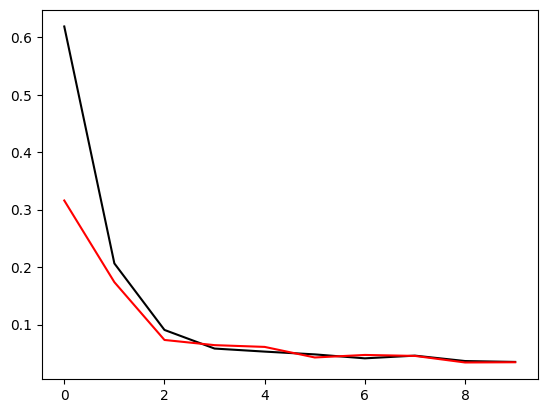

In [76]:
plt.plot(history.history["mean_squared_error"], c='k')
plt.plot(history.history["val_mean_squared_error"], c='r')
plt.show()

In [77]:
# evaluation mode
y_pred = model.predict(X_test)

ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_3" is incompatible with the layer: expected shape=(None, 1024), found shape=(None, 32, 32)


In [78]:
y_pred.shape

(668, 1024)

In [79]:
y_test.shape

(424, 32, 32)

ValueError: x and y must be the same size

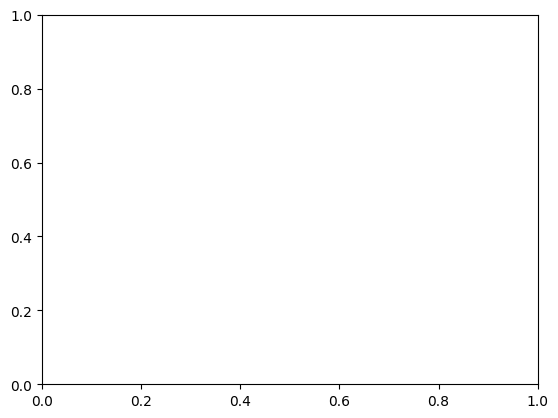

In [80]:
plt.scatter(y_test, y_pred)
plt.show()

In [ ]:
# evaluations
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred)

In [52]:
import keras as ks

In [81]:
bottleneck = ks.backend.function([model.layers[0].input,
                     model.layers[1].input,
                     model.layers[2].input],
 [model.layers[2].output])

ValueError: Found unvisited input tensors that are disconnected from the outputs: [<KerasTensor: shape=(None, 1024) dtype=float32 (created by layer 'input_4')>, <KerasTensor: shape=(None, 32) dtype=float32 (created by layer 'dense_12')>]

In [54]:
bot

In [55]:
#get_bottleneck = ks.backend.function([MIMO_AE.layers[0].input,
#                                      MIMO_AE.layers[1].input, MIMO_AE.layers[2].input],
#                                    [MIMO_AE.layers[10].output])

In [57]:
# saving model
model.save('autoencodersample.keras')

In [59]:
model2 = ks.models.load_model('autoencodersample.keras')

In [61]:
ypred2 = model2.predict(X_test)

21/21 [==============================] - 0s 3ms/step


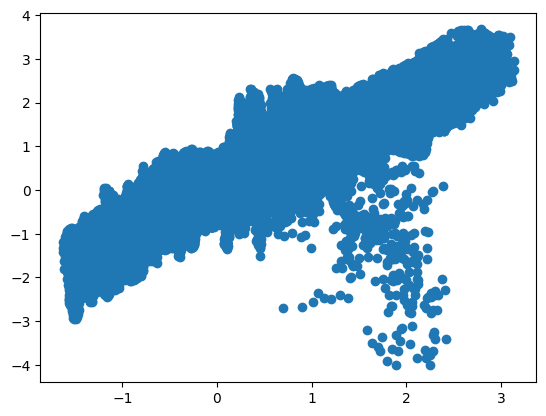

In [63]:
plt.scatter(ypred2, y_test)
plt.show()

## CNN Autoencoder

In [64]:
def z_score(da):
    """
    Compute z-score for training data.
    Normalizing data for ML model training.
    Args:
        da (array): Array of training variable.
    """
    return (da - np.mean(da)) / np.std(da)

def z_score_testing(da, testdata):
    """
    Compute z-score for testing data.
    Args:
        da (array): Array of training variable.
    """
    return (testdata - np.mean(da)) / np.std(da)

In [65]:
# reshape data to be samples, features
features_data = ds['ctt_grid'].values
print(features_data.shape)

(2224, 32, 32)


In [66]:
X_train, X_test, y_train, y_test = features_data[:1800], features_data[1800:], features_data[:1800], features_data[1800:]

In [67]:
X_test = z_score_testing(X_train, X_test) # input
y_test = z_score_testing(y_train, y_test) # label

X_train = z_score(X_train) # input
y_train = z_score(y_train) # label

In [68]:
# check shapes
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1800, 32, 32) (424, 32, 32) (1800, 32, 32) (424, 32, 32)


In [69]:
model = keras.Sequential()

# input
model.add(keras.Input(shape=(32, 32, 1)))  # 32x32 images

# encoder
# hidden layers
model.add(layers.Conv2D(100, 3, strides=1, padding="same", activation="relu"))
model.add(layers.MaxPooling2D(2))

model.add(layers.Conv2D(8, 3, strides=1, padding="same", activation="relu"))
model.add(layers.MaxPooling2D(2))

model.add(layers.Conv2D(4, 3, strides=1, padding="same", activation="relu"))
model.add(layers.MaxPooling2D(2))

# decoder
model.add(layers.Conv2D(4, 3, strides=1, padding="same", activation="relu"))
model.add(layers.UpSampling2D(2))

model.add(layers.Conv2D(8, 3, strides=1, padding="same", activation="relu"))
model.add(layers.UpSampling2D(2))

model.add(layers.Conv2D(16, 3, strides=1, padding="same", activation="relu"))
model.add(layers.UpSampling2D(2))

# Finally, we add last layer
model.add(layers.Conv2D(1, (3, 3), activation='linear', padding='same'))

# print model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 100)       1000      
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 100)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 8)         7208      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 8)           0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 4)           292       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 4, 4, 4)          

In [70]:
METRICS = [
    keras.metrics.MeanSquaredError(name='mean_squared_error'),
    keras.metrics.RootMeanSquaredError(name='root_mean_squared_error'),
]

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mean_squared_error",
    metrics=METRICS
)

BATCH_SIZE = 32
EPOCHS = 10

In [71]:
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.1,
    shuffle=True,
)

Epoch 1/10
51/51 [==============================] - 7s 118ms/step - loss: 0.6188 - mean_squared_error: 0.6188 - root_mean_squared_error: 0.7866 - val_loss: 0.3159 - val_mean_squared_error: 0.3159 - val_root_mean_squared_error: 0.5620
Epoch 2/10
51/51 [==============================] - 5s 90ms/step - loss: 0.2064 - mean_squared_error: 0.2064 - root_mean_squared_error: 0.4543 - val_loss: 0.1738 - val_mean_squared_error: 0.1738 - val_root_mean_squared_error: 0.4169
Epoch 3/10
51/51 [==============================] - 5s 91ms/step - loss: 0.0906 - mean_squared_error: 0.0906 - root_mean_squared_error: 0.3010 - val_loss: 0.0732 - val_mean_squared_error: 0.0732 - val_root_mean_squared_error: 0.2705
Epoch 4/10
51/51 [==============================] - 6s 114ms/step - loss: 0.0582 - mean_squared_error: 0.0582 - root_mean_squared_error: 0.2413 - val_loss: 0.0642 - val_mean_squared_error: 0.0642 - val_root_mean_squared_error: 0.2533
Epoch 5/10
51/51 [==============================] - 5s 90ms/step -

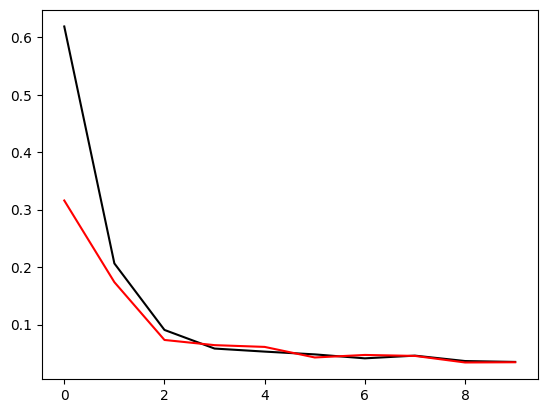

In [72]:
plt.plot(history.history["mean_squared_error"], c='k')
plt.plot(history.history["val_mean_squared_error"], c='r')
plt.show()

In [35]:
# saving model
# evaluation mode
# evaluations

In [ ]:
# for predict anomalies/outliers in the training dataset
#prediction = model.predict(test_feats_standardized.values)

# for get the mean absolute error between actual and reconstruction/prediction
#prediction_loss = keras.losses.mae(prediction, test_feats_standardized.values)

## CNN Autoencoder Noise Removal

In [36]:
def noise(array):
    """Adds random noise to each image in the supplied array."""
    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )
    return np.clip(noisy_array, 0.0, 1.0)

In [ ]:
# Create a copy of the data with added noise
#noisy_train_data = noise(train_data)
#noisy_test_data = noise(test_data)

In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_feats_standardized.values, test_feats_standardized.values, batch_size=128)
print(results)

In [ ]:


# for check the prediction loss threshold for 2% of outliers
#loss_threshold = np.percentile(np.mean(prediction_loss, axis=(1,2)), 98)

#print(f'The prediction loss threshold for 2% of outliers is {loss_threshold:.2f}')
# for visualize the threshold
#plt.hist(np.mean(prediction_loss, axis=(1,2)), bins=30, alpha=0.8)
#plt.axvline(x=loss_threshold, color='orange')
#plt.show()